In [44]:
import numpy             as np
import gvar              as gv
import matplotlib.pyplot as plt
import pandas            as pd
from tqdm import tqdm
import os
import pickle

In [45]:
from b2heavy.ThreePointFunctions.globalfit import RatioSet, show
from b2heavy.ThreePointFunctions.utils     import dump_fit_object, read_config_fit

In [46]:
readfrom = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'

In [48]:
MESON = 'Dst'
JK = False

In [49]:
RATIO_LIST = {
    'Dst': ['RA1','ZRA1','XFSTPAR','R0','R1','XV'],
    'D':   ['RPLUS','QPLUS','RMINUS','XF'],
}

ENSEMBLE_LIST = {
    'Dst':['Coarse-1','Coarse-2','Coarse-Phys','Fine-1'],
    'D'  :['MediumCoarse','Coarse-1','Coarse-2','Coarse-Phys','Fine-1','Fine-Phys','SuperFine'],
}


In [50]:
Rs = {}
for ens in ENSEMBLE_LIST[MESON]:
    # Read fit data
    tag = f'fit3pt_config_{ens}_{MESON}_global'
    out  = read_config_fit(tag,path=readfrom,jk=JK)
    pars = out if JK else out[-1]

    # Gather ratio values
    f0 = {}
    for k in pars:
        if k.endswith('f0'):
            rat,mom,_ = k.split('_')
            f0[mom,rat] = pars[k]

    momlist = sorted(set([m[0] for m in f0]))
    
    for mom in momlist:
        Rs[ens,mom] = {}
        for ratio in RATIO_LIST[MESON]:
            if (mom,ratio) in f0:
                r = ratio if ratio!='ZRA1' else 'RA1'
                Rs[ens,mom][r] = f0[mom,ratio]

                if r=='RA1':
                    Rs[ens,mom][r] = np.sqrt(Rs[ens,mom][r])

                if JK:
                    Njk = len(f0[mom,ratio])

        if mom=='000':
            Rs[ens,mom]['w'] = np.full(Njk,1.) if JK else gv.gvar('1.000000000(1)')
        else:
            xf = Rs[ens,mom]['XF' if MESON=='D' else 'XFSTPAR']
            Rs[ens,mom]['w'] = (1+xf**2)/(1-xf**2)

            if MESON=='D':
                Rs[ens,mom]['RPLUS'] = Rs[ens,'000']['RPLUS']

# Define form factors

In [52]:
def ha1(dfz):
    return 2*dfz['RA1']/(dfz['w']+1)

def ha2(dfz):
    return 2*dfz['RA1']/(dfz['w']**2-1) * ((dfz['w']*dfz['R1']) - (dfz['w']**2-1.)**0.5 * (-1) * dfz['R0'] - 1)

def ha3(dfz):
    return 2*dfz['RA1']/(dfz['w']**2-1) * (dfz['w'] - dfz['R1'])

def hv(dfz):
    return 2*dfz['RA1']/((dfz['w']**2-1)**0.5) * dfz['XV']

def hplus(dfz):
    return dfz['RPLUS']**0.5 * dfz['QPLUS'] * (1. - dfz['RMINUS']*dfz['XF'])

def hminus(dfz):
    return dfz['RPLUS']**0.5 * dfz['QPLUS'] * (1. - dfz['RMINUS']/dfz['XF'])

In [54]:
ffutils = {
    'Dst': {
        'func': [ha1  ,ha2  ,ha3  ,hv  ],
        'name': ['hA1','hA2','hA3','hV']
    },
    'D': {
        'func' : [hplus, hminus],
        'name' : ['h+' , 'h-']
    }
}

In [55]:
ffs = {k: {} for k in Rs}

for ens,mom in Rs:
    ffs[ens,mom]['w'] = Rs[ens,mom]['w']
    for func,name in zip(ffutils[MESON]['func'],ffutils[MESON]['name']):
        try:
            try:
                ffs[ens,mom][name] = func(Rs[ens,mom])
            except ZeroDivisionError:
                continue
        except KeyError:
            continue

In [56]:
ffs[ens,mom][name] = func(Rs[ens,mom])

In [57]:
ff = pd.DataFrame(ffs).transpose()

In [58]:
ff

w         hA1          hA2        hA3  \
Coarse-1    000  1.0000000000(10)  0.9139(51)          NaN        NaN   
            100        1.0119(14)   0.879(20)     0.67(91)  -0.12(91)   
            200        1.0418(40)   0.849(26)    -0.50(37)   1.02(34)   
            300        1.0860(92)   0.808(41)    -0.80(31)   1.33(28)   
Coarse-2    000  1.0000000000(10)  0.9145(49)          NaN        NaN   
            100        1.0245(25)   0.843(11)    -0.30(42)   0.70(40)   
            200        1.0935(86)   0.789(20)    -0.44(25)   0.91(22)   
            300         1.156(19)   0.660(71)    -1.04(29)   1.38(26)   
Coarse-Phys 000  1.0000000000(10)  0.9104(39)          NaN        NaN   
            100       1.00552(44)  0.8958(75)     1.4(1.4)  -0.9(1.4)   
            200        1.0223(12)   0.874(10)  -0.003(406)   0.52(39)   
            300        1.0498(26)   0.783(31)    -0.30(27)   0.80(25)   
            400        1.0896(51)   0.793(19)    -0.55(24)   1.13(21)   
Fine-1      000  1.0000000000(10)  0.9146(45)          NaN        NaN   
            100       1.01203(97)   0.892(14)    -2.34(98)   2.97(96)   
            200        1.0409(23)   0.863(11)    -0.48(34)   1.08(32)   
            300        1.0873(53)   0.803(17)    -0.38(20)   1.00(18)   
            400         1.138(11)   0.681(63)    -0.54(21)   1.05(19)   

                        hV  
Coarse-1    000        NaN  
            100  1.345(92)  
            200  1.340(82)  
            300  1.232(98)  
Coarse-2    000        NaN  
            100  1.127(66)  
            200  1.080(69)  
            300   0.97(13)  
Coarse-Phys 000        NaN  
            100  1.313(70)  
            200  1.253(45)  
            300  1.084(55)  
            400  1.038(46)  
Fine-1      000        NaN  
            100  1.153(56)  
            200  1.203(42)  
            300  1.136(49)  
            400   1.01(11)

# Plots $D^*$

In [59]:
from plot_kwargs import kwargs

In [60]:
mask = {
    'hA2': {
        'Coarse-1'   : [      '200','300'      ],
        'Coarse-2'   : ['100','200','300'      ],
        'Coarse-Phys': [            '300','400'],
        'Fine-1'     : [      '200','300','400'],
    },
    'hA3': {
        'Coarse-1'   : [      '200','300'      ],
        'Coarse-2'   : ['100','200','300'      ],
        'Coarse-Phys': [      '200','300','400'],
        'Fine-1'     : [      '200','300','400'],
    }
}

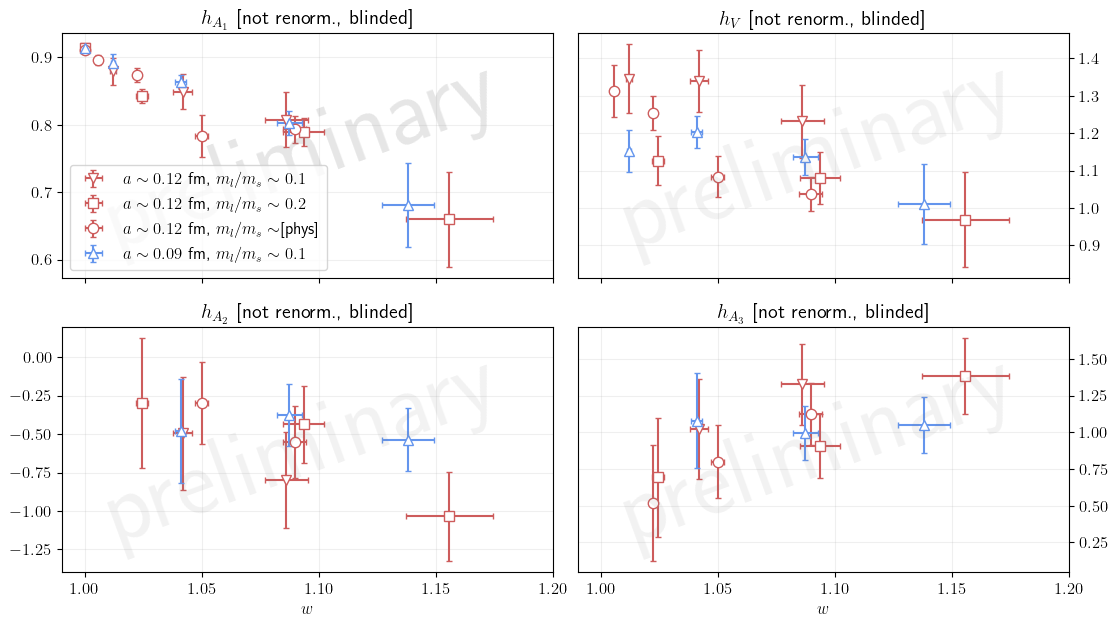

In [61]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12


fig,ax = plt.subplots(2,2,figsize=(13,7),sharex=True)

ah1 = ax[0,0]
ah2 = ax[1,0]
ah3 = ax[1,1]
ahv = ax[0,1]


for ens in ENSEMBLE_LIST[MESON]:
    x = ff['w'  ].loc[ens].values
    y = ff['hA1'].loc[ens].values
    ah1.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

    x = ff['w'  ].loc[ens,mask['hA2'][ens]].values
    y = ff['hA2'].loc[ens,mask['hA2'][ens]].values
    ah2.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

    x = ff['w'  ].loc[ens,mask['hA3'][ens]].values
    y = ff['hA3'].loc[ens,mask['hA3'][ens]].values
    ah3.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])
    
    x = ff['w'  ].loc[ens].values
    y = ff['hV'].loc[ens].values
    ahv.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])


ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()


ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()


ah1.set_title(r'$h_{A_1}$ [not renorm., blinded]')
# ah1.set_xlabel(r'$w$')
ah1.grid(alpha=0.2)
ah1.set_xlim(0.99,1.2)
ah1.set_xticks([1.,1.05,1.1,1.15,1.2])
# ah1.legend(bbox_to_anchor=[1.3, 1.6])
ah1.legend()

ah1.text(0.5, 0.5, 'preliminary', transform=ah1.transAxes,
        fontsize=70, color='gray', alpha=0.1,
        ha='center', va='center', rotation=20)



ah2.set_title(r'$h_{A_2}$ [not renorm., blinded]')
ah2.set_xlabel(r'$w$')
ah2.grid(alpha=0.2)
ah2.set_xlim(0.99,1.2)
ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

ah3.set_title(r'$h_{A_3}$ [not renorm., blinded]')
ah3.set_xlabel(r'$w$')
ah3.grid(alpha=0.2)
ah3.set_xlim(0.99,1.2)
ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

ahv.set_title(r'$h_{V}$ [not renorm., blinded]'  )
# ahv.set_xlabel(r'$w$')
ahv.grid(alpha=0.2)
ahv.set_xlim(0.99,1.2)
ah1.set_xticks([1.,1.05,1.1,1.15,1.2])

for ax in [ah1,ah2,ah3,ahv]:
    ax.text(0.5, 0.5, 'preliminary', transform=ax.transAxes,
        fontsize=70, color='gray', alpha=0.1,
        ha='center', va='center', rotation=20)



plt.subplots_adjust(wspace=0.05, hspace=0.2)

plt.savefig(
    f'/Users/pietro/code/latex/Lattice2024/beamer-presentation-template/PLOTS/form_factors_Dst.pdf',
    transparent=True    
)


# Plot $D$

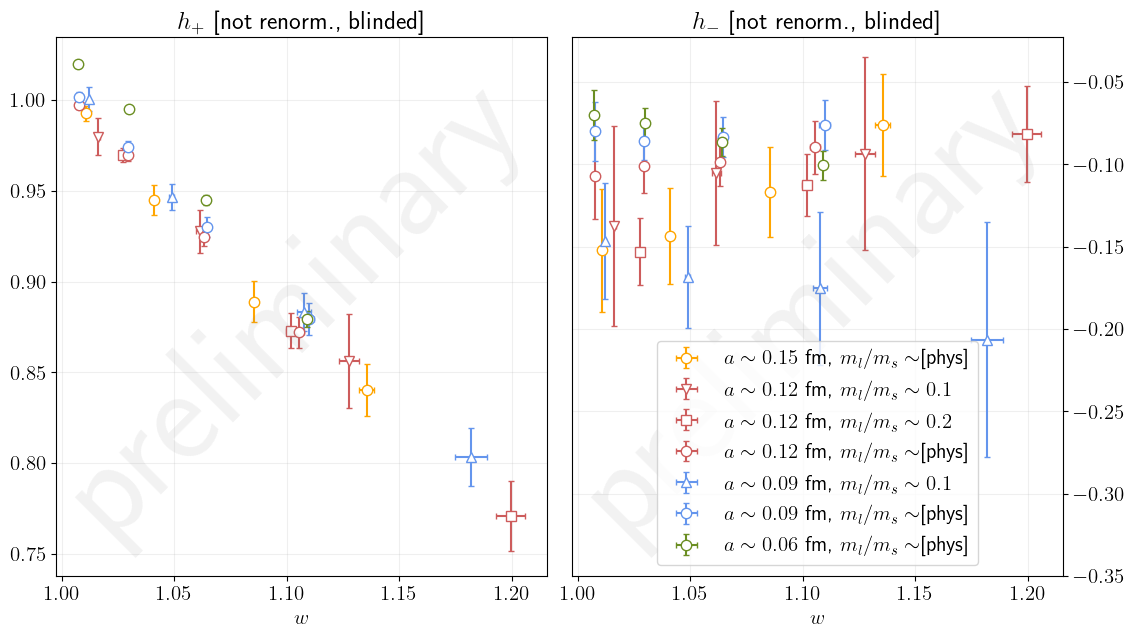

In [43]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 15


fig,ax = plt.subplots(1,2,figsize=(13,7),sharex=True)

ap = ax[0]
am = ax[1]


for ens in ENSEMBLE_LIST[MESON]:
    x = ff['w' ].loc[ens].values
    y = ff['h+'].loc[ens].values
    ap.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])

    x = ff['w' ].loc[ens].values
    y = ff['h-'].loc[ens].values
    am.errorbar(gv.mean(x),gv.mean(y),xerr = gv.sdev(x),yerr = gv.sdev(y),**kwargs[ens])


ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()


ap.set_title(r'$h_{+}$ [not renorm., blinded]')
ap.grid(alpha=0.2)
ap.set_xlabel(r'$w$')
# ap.legend(loc='upper right')


am.set_title(r'$h_{-}$ [not renorm., blinded]')
am.grid(alpha=0.2)
am.legend(loc='lower center')
am.set_ylim(ymin=-0.35)
am.set_xlabel(r'$w$')

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.subplots_adjust(wspace=0.05)

am.text(0.5, 0.5, 'preliminary', transform=am.transAxes,
        fontsize=100, color='gray', alpha=0.1,
        ha='center', va='center', rotation=45)

ap.text(0.5, 0.5, 'preliminary', transform=ap.transAxes,
        fontsize=100, color='gray', alpha=0.1,
        ha='center', va='center', rotation=45)


plt.savefig(
    f'/Users/pietro/code/latex/Lattice2024/beamer-presentation-template/PLOTS/form_factors_D.pdf',
    transparent=True    
)

